   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 79.2 MB/s eta 0:00:00
--- Step 1: Environment setup complete ---

--- Step 2: Defining helper functions for AI models ---

--- Step 3: Upload your video and initialize models ---
Please upload a video file (.mp4, .mov, etc.)


Saving testing_video.mp4 to testing_video.mp4
Video 'testing_video.mp4' uploaded successfully.
Loading ZoeDepth model 'Intel/zoedepth-nyu-kitti'...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/723 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.38G [00:00<?, ?B/s]

Downloading: "http://cmp.felk.cvut.cz/~mishkdmy/models/loftr_outdoor.ckpt" to /root/.cache/torch/hub/checkpoints/loftr_outdoor.ckpt


100%|██████████| 44.2M/44.2M [00:02<00:00, 16.0MB/s]



--- Step 4: Setting Camera Parameters ---
Video Properties: 848x478 @ 30.00 FPS
Using estimated camera intrinsics based on a modern smartphone sensor.
For best results, calibrate your specific camera.
[[848.   0. 424.]
 [  0. 848. 239.]
 [  0.   0.   1.]]

--- Step 5: Running Visual Odometry pipeline on the video ---


Processing Video:   0%|          | 0/331 [00:00<?, ?it/s]


--- Step 6: Visualizing Odometry and Speed Results ---


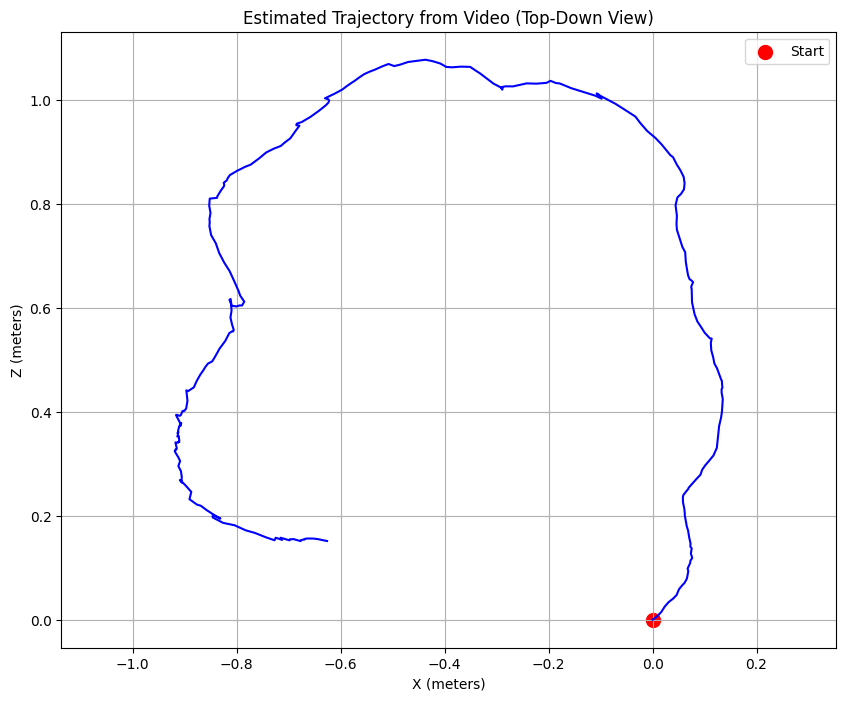

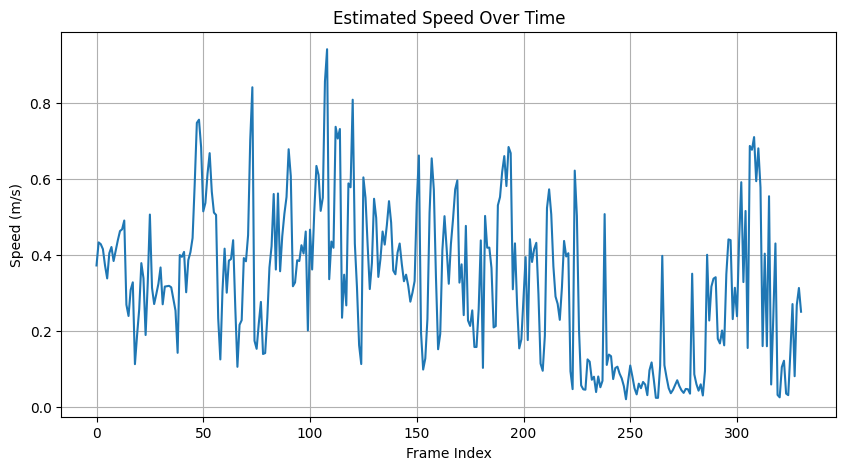


✅ Video Processing complete.
Final estimated position (X, Y, Z): (-0.63, -0.59, 0.15) meters
Average speed: 0.33 m/s


In [1]:
# ==============================================================================
# STEP 1: SETUP AND IMPORTS
# ==============================================================================
# Install Kornia for LoFTR and other necessary libraries
!pip install -q kornia kornia_rs opencv-python matplotlib tqdm transformers

import os
import numpy as np
import torch
import cv2
from PIL import Image
import kornia as K
import kornia.feature as KF
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from transformers import AutoImageProcessor, AutoModelForDepthEstimation
from google.colab import files

print("--- Step 1: Environment setup complete ---")

# ==============================================================================
# STEP 2: DEFINE HELPER FUNCTIONS FOR MODELS
# ==============================================================================
print("\n--- Step 2: Defining helper functions for AI models ---")

def load_zoedepth_hf(model_id="Intel/zoedepth-nyu-kitti", device="cuda"):
    print(f"Loading ZoeDepth model '{model_id}'...")
    processor = AutoImageProcessor.from_pretrained(model_id)
    model = AutoModelForDepthEstimation.from_pretrained(model_id).to(device).eval()
    return processor, model

def zoedepth_predict(processor, model, img_bgr, device="cuda"):
    pil_img = Image.fromarray(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
    inputs = processor(images=pil_img, return_tensors="pt").to(device)
    with torch.no_grad():
        out = model(**inputs)
    h, w = img_bgr.shape[:2]
    predicted_depth = torch.nn.functional.interpolate(
        out.predicted_depth.unsqueeze(1), size=(h, w), mode="bicubic", align_corners=False
    ).squeeze()
    return predicted_depth.cpu().numpy().astype(np.float32)

# ==============================================================================
# STEP 3: UPLOAD VIDEO AND INITIALIZE MODELS
# ==============================================================================
print("\n--- Step 3: Upload your video and initialize models ---")

# --- Upload Video File ---
print("Please upload a video file (.mp4, .mov, etc.)")
uploaded = files.upload()
if not uploaded:
    raise Exception("No video file was uploaded. Please run the cell again.")
VIDEO_PATH = list(uploaded.keys())[0]
print(f"Video '{VIDEO_PATH}' uploaded successfully.")

# --- Models and Configuration ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
zoe_processor, zoe_model = load_zoedepth_hf(device=DEVICE)
loftr = KF.LoFTR(pretrained='outdoor').to(DEVICE).eval()

# ==============================================================================
# ❗ STEP 4: CAMERA CALIBRATION - UPDATED ASSUMPTION
# ==============================================================================
print("\n--- Step 4: Setting Camera Parameters ---")

# Open the video to get its properties (width, height, FPS)
cap = cv2.VideoCapture(VIDEO_PATH)
W = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
H = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
FPS = cap.get(cv2.CAP_PROP_FPS)
cap.release()

print(f"Video Properties: {W}x{H} @ {FPS:.2f} FPS")

# --- CAMERA INTRINSICS (K matrix) ---
# This is an EDUCATED GUESS based on the Sony IMX882 sensor.
# Modern phone cameras typically have a focal length roughly equal to the image width.
# This is a much better starting point than a generic multiplier.
# For truly accurate results, you MUST replace this with your calibrated values.
FOCAL_LENGTH_X = W
FOCAL_LENGTH_Y = W # Assuming square pixels, so fx is usually close to fy
OPTICAL_CENTER_X = W / 2
OPTICAL_CENTER_Y = H / 2

K_CAM = np.array([
    [FOCAL_LENGTH_X, 0, OPTICAL_CENTER_X],
    [0, FOCAL_LENGTH_Y, OPTICAL_CENTER_Y],
    [0, 0, 1]
], dtype=np.float32)

print("Using estimated camera intrinsics based on a modern smartphone sensor.")
print("For best results, calibrate your specific camera.")
print(K_CAM)

# ==============================================================================
# STEP 5: RUN VISUAL ODOMETRY ON THE VIDEO
# ==============================================================================
print("\n--- Step 5: Running Visual Odometry pipeline on the video ---")

# --- Initialize Odometry Variables ---
R_total, T_total = np.eye(3), np.zeros((3, 1))
trajectory = [T_total.flatten()]
speeds = []
dt = 1.0 / FPS if FPS > 0 else 0.033 # Avoid division by zero

# --- Process Video ---
cap = cv2.VideoCapture(VIDEO_PATH)
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

ret, prev_frame_bgr = cap.read()
if not ret:
    raise Exception("Could not read the first frame of the video.")

for frame_idx in tqdm(range(total_frames - 1), desc="Processing Video"):
    ret, curr_frame_bgr = cap.read()
    if not ret:
        break

    # 1. Predict depth for the previous frame
    depth_map = zoedepth_predict(zoe_processor, zoe_model, prev_frame_bgr, device=DEVICE)

    # 2. Prepare images for LoFTR
    img0_tensor = K.image_to_tensor(cv2.cvtColor(prev_frame_bgr, cv2.COLOR_BGR2GRAY), False).float() / 255.
    img1_tensor = K.image_to_tensor(cv2.cvtColor(curr_frame_bgr, cv2.COLOR_BGR2GRAY), False).float() / 255.
    input_dict = {"image0": img0_tensor.to(DEVICE), "image1": img1_tensor.to(DEVICE)}

    # 3. Perform LoFTR matching
    with torch.no_grad():
        correspondences = loftr(input_dict)

    conf = correspondences['confidence'].cpu().numpy()
    mask = conf > 0.9
    if mask.sum() < 10:
        prev_frame_bgr = curr_frame_bgr
        continue

    mkpts0 = correspondences['keypoints0'].cpu().numpy()[mask]
    mkpts1 = correspondences['keypoints1'].cpu().numpy()[mask]

    # 4. Get 3D points from depth map
    pts_3d, pts_2d = [], []
    for pt0, pt1 in zip(mkpts0, mkpts1):
        x, y = int(pt0[0]), int(pt0[1])
        d = depth_map[y, x]
        if d > 0.1: # Filter out noise
            X = (x - K_CAM[0, 2]) * d / K_CAM[0, 0]
            Y = (y - K_CAM[1, 2]) * d / K_CAM[1, 1]
            pts_3d.append([X, Y, d])
            pts_2d.append(pt1)

    if len(pts_3d) < 10:
        prev_frame_bgr = curr_frame_bgr
        continue

    # 5. Estimate pose
    success, rvec, tvec, _ = cv2.solvePnPRansac(np.array(pts_3d), np.array(pts_2d), K_CAM, None)
    if not success or rvec is None:
        prev_frame_bgr = curr_frame_bgr
        continue

    # 6. Accumulate pose and calculate speed
    R, _ = cv2.Rodrigues(rvec)
    R_inv, t_inv = R.T, -R.T @ tvec

    distance = np.linalg.norm(t_inv)
    speeds.append(distance / dt)

    T_total = T_total + R_total @ t_inv
    R_total = R_inv @ R_total
    trajectory.append(T_total.flatten())

    # Update the previous frame
    prev_frame_bgr = curr_frame_bgr

cap.release()

# ==============================================================================
# STEP 6: VISUALIZE RESULTS
# ==============================================================================
print("\n--- Step 6: Visualizing Odometry and Speed Results ---")

trajectory = np.array(trajectory)
speeds = np.array(speeds)

# Plot the 2D trajectory
plt.figure(figsize=(10, 8))
plt.plot(trajectory[:, 0], trajectory[:, 2], 'b-')
plt.scatter(trajectory[0, 0], trajectory[0, 2], c='r', marker='o', s=100, label='Start')
plt.title('Estimated Trajectory from Video (Top-Down View)')
plt.xlabel('X (meters)')
plt.ylabel('Z (meters)')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()

# Plot the speed
plt.figure(figsize=(10, 5))
plt.plot(speeds)
plt.title('Estimated Speed Over Time')
plt.xlabel('Frame Index')
plt.ylabel('Speed (m/s)')
plt.grid(True)
plt.show()

print(f"\n✅ Video Processing complete.")
print(f"Final estimated position (X, Y, Z): ({T_total[0,0]:.2f}, {T_total[1,0]:.2f}, {T_total[2,0]:.2f}) meters")
if len(speeds) > 0:
    print(f"Average speed: {np.mean(speeds):.2f} m/s")